In [1]:
import json
import os
import pickle
import shutil

import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml


2023-06-21 17:26:11.167438: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 17:26:11.819097: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 17:26:11.831604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 17:26:16.584411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Loading data for cases

In [4]:
def get_dirs(base_path):
    return [os.path.join(base_path, d) for d in next(os.walk(base_path))[1]]

def load_yaml(path):
    with open(path, encoding="utf-8") as f:
        return yaml.safe_load(f)

def load_model_data_to_dict(base_path):
    return {
        "confusion_matrix_validation": np.load(os.path.join(base_path, "Callbacks", "epoch_end_confusion_matrix.npy")),
        "f_weighted_validation": np.load(os.path.join(base_path, "Callbacks", "epoch_end_f1_weighted.npy")),
        "metrics": pd.read_csv(os.path.join(base_path, "Metrics_and_losses.csv"), index_col=None),
        "config": load_yaml(os.path.join(base_path, "config.yaml")),
        "x_train": np.load(os.path.join(base_path, "Data/x_train.npy")),
        "y_train": np.load(os.path.join(base_path, "Data/y_train.npy")),
        "x_validation": np.load(os.path.join(base_path, "Data/x_validation.npy")),
        "y_validation": np.load(os.path.join(base_path, "Data/y_validation.npy")),
        "x_test": np.load(os.path.join(base_path, "Data/x_test.npy")),
        "y_test": np.load(os.path.join(base_path, "Data/y_test.npy")),
        
    }
def rowname_generate(_conv_lay_count, _dense_lay_units):
    _dense_lay_units = [str(i) for i in _dense_lay_units]
    return f"Warstwy konwolucyjne: {_conv_lay_count}, jednostki warstw gęstości: {', '.join(_dense_lay_units)}"



In [3]:
path_dir_cnn = os.path.join("Models", "Final", "CNN")
path_dir_cdt = os.path.join("Models", "Final", "CDT_1D")

if not os.path.exists("tmp_cnn_result.pickle") or False:
    case_dirs_cnn = {
        os.path.basename(d): {
            model_path: load_model_data_to_dict(model_path) for model_path in get_dirs(d)
        } for d in get_dirs(path_dir_cnn)
    }

    with open("tmp_cnn_result.pickle", "wb") as f:
        pickle.dump(case_dirs_cnn, f)
else:
    with open("tmp_cnn_result.pickle", "rb") as f:
        case_dirs_cnn = pickle.loads(f.read())

if not os.path.exists("tmp_cdt_result.pickle") or False:
    case_dirs_cdt = {
        os.path.basename(d): {
            model_path: load_model_data_to_dict(model_path) for model_path in get_dirs(d)
        } for d in get_dirs(path_dir_cdt)
    }

    with open("tmp_cdt_result.pickle", "wb") as f:
        pickle.dump(case_dirs_cdt, f)
else:
    with open("tmp_cdt_result.pickle", "rb") as f:
        case_dirs_cdt = pickle.loads(f.read())


# Plots

## Metryki jednowartościowe

In [5]:
def plot_metric_by_one_case(dataset, metric, model = "cnn", metric_extra = None, title = "Trajektoria metryki."):
    _case_dirs = case_dirs_cnn if model == "cnn" else case_dirs_cdt
    _case_dirs = _case_dirs[dataset]
    if metric_extra is None:
        _case_dirs = {
            k: {
                "data": _case_dirs[k][metric],
                "config": _case_dirs[k]["config"],
            } for k in _case_dirs.keys()
        }
    else:
        _case_dirs = {
            k: {
                "data": _case_dirs[k][metric][metric_extra].values,
                "config": _case_dirs[k]["config"],
            } for k in _case_dirs.keys()
        }

    for k in _case_dirs.keys():
        d = _case_dirs[k]
        t = json.dumps(d["config"], sort_keys=True, indent=2)
        y = d["data"]
        x = range(1, len(y)+1)


        fig = plt.figure(figsize=(10, 8))
        fig.suptitle(title)


        ax = fig.add_subplot()
        x_tics = np.arange(0, len(x) + 11, 5)
        ax.set_xticks(x_tics)
        ax.set_xticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(x_tics)])
        ax.set_xlabel("Numer epoki")

        ax.set_ylim(0, 1)
        y_tics = np.arange(0, 1.05, 0.05)
        ax.set_yticks(y_tics)
        ax.set_yticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(y_tics)])
        ax.set_ylabel("Wartość metryki")

        ax.grid(axis="both")
        ax.plot(x, y)

        fig.text(1.01, 0, t, ha='left', wrap=False)

        fig.tight_layout()
        fig.subplots_adjust(top=0.9)
        
        if metric_extra is None:
            path_to_save = os.path.join("tmp_plots", model, dataset, metric, "_".join(k.split(os.sep)) + ".png")
        else:
            path_to_save = os.path.join("tmp_plots", model, dataset, metric_extra, "_".join(k.split(os.sep)) + ".png")
        os.makedirs(os.path.dirname(path_to_save), exist_ok=True)
        fig.savefig(path_to_save, bbox_inches='tight')

        plt.close()



In [ ]:
for ds in case_dirs_cnn.keys():
    plot_metric_by_one_case(ds, "f_weighted_validation", model="cnn", metric_extra=None,
                            title="Trajektoria wartości metryki F ważonej dla zbioru walidacyjnego,\nw procesie trenowania modelu.")

for ds in case_dirs_cnn.keys():
    plot_metric_by_one_case(ds, "metrics", model="cnn", metric_extra="loss",
    title="Trajektoria wartości funkcji kary kategorycznej entropii krzyżowej dla zbioru treningowego,\nw procesie trenowania modelu."
    )
    plot_metric_by_one_case(ds, "metrics", model="cnn", metric_extra="val_loss",
    title="Trajektoria wartości funkcji kary kategorycznej entropii krzyżowej dla zbioru walidacyjnego,\nw procesie trenowania modelu."
    )
    plot_metric_by_one_case(ds, "metrics", model="cnn", metric_extra="f1_m",
    title="Trajektoria wartości metryki F1 dla zbioru treningowego,\nw procesie trenowania modelu."
    )
    plot_metric_by_one_case(ds, "metrics", model="cnn", metric_extra="val_f1_m",
    title="Trajektoria wartości metryki F1 dla zbioru walidacyjnego,\nw procesie trenowania modelu."
    )


In [34]:
for ds in case_dirs_cdt.keys():
    plot_metric_by_one_case(ds, "f_weighted_validation", model="cdt", metric_extra=None,
                            title="Trajektoria wartości metryki F ważonej dla zbioru walidacyjnego,\nw procesie trenowania modelu.")

for ds in case_dirs_cdt.keys():
    plot_metric_by_one_case(ds, "metrics", model="cdt", metric_extra="loss",
    title="Trajektoria wartości funkcji kary kategorycznej entropii krzyżowej dla zbioru treningowego,\nw procesie trenowania modelu."
    )
    plot_metric_by_one_case(ds, "metrics", model="cdt", metric_extra="val_loss",
    title="Trajektoria wartości funkcji kary kategorycznej entropii krzyżowej dla zbioru walidacyjnego,\nw procesie trenowania modelu."
    )
    plot_metric_by_one_case(ds, "metrics", model="cdt", metric_extra="f1_m",
    title="Trajektoria wartości metryki F1 dla zbioru treningowego,\nw procesie trenowania modelu."
    )
    plot_metric_by_one_case(ds, "metrics", model="cdt", metric_extra="val_f1_m",
    title="Trajektoria wartości metryki F1 dla zbioru walidacyjnego,\nw procesie trenowania modelu."
    )


### Mean and std

In [62]:
case_dirs_cdt["all"]["Models/Final/CDT_1D/all/2023-06-11_22-23-55_0"]["metrics"]["f1_m"].values[-1]

0.3548833429813385

In [63]:
def table_with_mean_and_std_of_final_metric_value(metric, metric_extra = None, title = "Trajektoria metryki."):
    df = pd.concat([
        _table_with_mean_and_std_of_final_metric_value(case_dirs_cnn, metric, " dla CDT", metric_extra, title),
        _table_with_mean_and_std_of_final_metric_value(case_dirs_cdt, metric, " dla CNN", metric_extra, title),
    ])
    df = df.reindex([df.index.to_list()[i] for i in [0,2,1,3]])
    df.columns = [col.replace("_5", "") for col in df.columns]
    df.columns = [col.replace("_", " ") for col in df.columns]
    df.columns = [col.replace("Crude Oil", "Ropa naftowa") for col in df.columns]
    df.columns = [col.replace("all", "Wszystkie") for col in df.columns]
    return df
    

def _table_with_mean_and_std_of_final_metric_value(_case_dirs, metric, row_suffix, metric_extra = None, title = "Trajektoria metryki."):
    _df_validation_dict = {d: {} for d in _case_dirs.keys()}
    
    for d in _case_dirs.keys():
        value_list = []
        for _m in _case_dirs[d].keys():
            _case = _case_dirs[d][_m]

            _config = _case["config"]
            _conv_lay_count = _config["convolution_layers_count"]
            _dense_lay_units = _config["dense_layers_units"]
            if metric_extra is None:
                value_list.append(_case[metric][-1])
            else:
                value_list.append(_case[metric][metric_extra].values[-1])
            


        _df_validation_dict[d]["Średnia" + row_suffix] = np.mean(value_list)
        _df_validation_dict[d]["Odchylenie standardowe" + row_suffix] = np.std(value_list)

    return pd.DataFrame(_df_validation_dict)





In [65]:
df = table_with_mean_and_std_of_final_metric_value(metric="f_weighted_validation")
print(df.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & Wszystkie & Amazon & Apple & Ropa naftowa & DJI & Meta & Tesla \\
\midrule
Średnia dla CDT & 0.486927 & 0.565832 & 0.524757 & 0.347374 & 0.309053 & 0.590656 & 0.587962 \\
Średnia dla CNN & 0.498071 & 0.597950 & 0.509799 & 0.309985 & 0.275445 & 0.568826 & 0.586595 \\
Odchylenie standardowe dla CDT & 0.028449 & 0.076135 & 0.028407 & 0.026894 & 0.021819 & 0.011996 & 0.014752 \\
Odchylenie standardowe dla CNN & 0.071179 & 0.081870 & 0.050554 & 0.049133 & 0.039878 & 0.021391 & 0.012832 \\
\bottomrule
\end{tabular}



In [66]:
df = table_with_mean_and_std_of_final_metric_value(metric="metrics", metric_extra="f1_m")
print(df.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & Wszystkie & Amazon & Apple & Ropa naftowa & DJI & Meta & Tesla \\
\midrule
Średnia dla CDT & 0.835367 & 0.733036 & 0.965020 & 0.938050 & 0.943827 & 0.978688 & 0.993146 \\
Średnia dla CNN & 0.259286 & 0.154583 & 0.436385 & 0.490812 & 0.522595 & 0.412679 & 0.459999 \\
Odchylenie standardowe dla CDT & 0.046676 & 0.051812 & 0.023972 & 0.044856 & 0.093543 & 0.018164 & 0.009230 \\
Odchylenie standardowe dla CNN & 0.128949 & 0.178956 & 0.302736 & 0.223215 & 0.288057 & 0.284559 & 0.330182 \\
\bottomrule
\end{tabular}



In [67]:
df = table_with_mean_and_std_of_final_metric_value(metric="metrics", metric_extra="val_f1_m")
print(df.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & Wszystkie & Amazon & Apple & Ropa naftowa & DJI & Meta & Tesla \\
\midrule
Średnia dla CDT & 0.352397 & 0.250219 & 0.363435 & 0.434609 & 0.373247 & 0.371864 & 0.359555 \\
Średnia dla CNN & 0.203682 & 0.064204 & 0.205887 & 0.368833 & 0.288045 & 0.196207 & 0.212023 \\
Odchylenie standardowe dla CDT & 0.027781 & 0.033639 & 0.020954 & 0.022958 & 0.015891 & 0.015205 & 0.008411 \\
Odchylenie standardowe dla CNN & 0.067236 & 0.075972 & 0.118776 & 0.072217 & 0.081313 & 0.113313 & 0.116762 \\
\bottomrule
\end{tabular}



## Confusion matrix

In [6]:
cm_label_dict = {
    (0, 0): "Predykcja spadek",
    (0, 1): "Predykcja stałe",
    (0, 2): "Predykcja wzrost",
    (1, 0): "Prawdziwe spadek",
    (1, 1): "Prawdziwe stałe",
    (1, 2): "Prawdziwe wzrost",
}

cm_color_dict = {
    (0, 0): mpl.colormaps["tab20c"](2),
    (1, 0): mpl.colormaps["tab20c"](1),
    (2, 0): mpl.colormaps["tab20c"](0),

    (0, 1): mpl.colormaps["tab20c"](6),
    (1, 1): mpl.colormaps["tab20c"](5),
    (2, 1): mpl.colormaps["tab20c"](4),

    (0, 2): mpl.colormaps["tab20c"](10),
    (1, 2): mpl.colormaps["tab20c"](9),
    (2, 2): mpl.colormaps["tab20c"](8),
}

cm_color_dict = {
    0: mpl.colormaps["tab20c"](4),
    1: mpl.colormaps["tab20c"](0),
    2: mpl.colormaps["tab20c"](8),
}

cm_marker_dict = {
    0: 7,
    1: 5,
    2: 6,
}


In [45]:
def plot_confusion_by_one_case(dataset, model = "cnn"):
    metric = "confusion_matrix_validation"
    title = "Wizualizacja trajektorii elementów macierzy pomyłek dla zbioru walidacyjnego, unormowane względem liczności klasy,\nw procesie trenowania modelu."

    _case_dirs = case_dirs_cnn if model == "cnn" else case_dirs_cdt
    _case_dirs = _case_dirs[dataset]
    _case_dirs = {
        k: {
            "data": _case_dirs[k][metric],
            "config": _case_dirs[k]["config"],
        } for k in _case_dirs.keys()
    }

    for k in _case_dirs.keys():
        _plot_label_config_store = []
        
        d = _case_dirs[k]
        t = json.dumps(d["config"], sort_keys=True, indent=2)
        y_matrix = d["data"]
        y_matrix_freq = y_matrix / y_matrix[0].sum(axis=1).reshape((-1,1))
        
        x = range(1, y_matrix_freq.shape[0]+1)


        fig = plt.figure(figsize=(10, 8))
        fig.suptitle(title)


        ax = fig.add_subplot()
        x_tics = np.arange(0, len(x) + 11, 5)
        ax.set_xticks(x_tics)
        ax.set_xticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(x_tics)])
        ax.set_xlabel("Numer epoki")

        ax.set_ylim(-0.05, 1.05)
        y_tics = np.arange(0, 1.05, 0.05)
        ax.set_yticks(y_tics)
        ax.set_yticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(y_tics)])
        ax.set_ylabel("Wartość metryki")

        ax.grid(axis="both")
        
        for row in range(y_matrix_freq.shape[1]):
            for col in range(y_matrix_freq.shape[2]):
                y = y_matrix_freq[:, row, col]

                if (0, col) not in _plot_label_config_store:
                    _plot_label_config_store.append((0, col))
                    _label = cm_label_dict[(0, col)]
                else:
                    _label = None
                ax.plot(x, y, linewidth=1,
                        c=cm_color_dict[col],
                        label=_label)

                if (1, row) not in _plot_label_config_store:
                    _plot_label_config_store.append((1, row))
                    _label = cm_label_dict[(1, row)]
                else:
                    _label = None
                ax.scatter(x, y,
                        marker=cm_marker_dict[row],
                        c=cm_color_dict[row],
                        label=_label)


        handles, labels = plt.gca().get_legend_handles_labels()
        order = [5,4,1, 3,2,0]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

        fig.text(1.01, 0, t, ha='left', wrap=False)

        fig.tight_layout()
        fig.subplots_adjust(top=0.9)
        
        path_to_save = os.path.join("tmp_plots", model, dataset, "confusion_matrix", "_".join(k.split(os.sep)) + ".png")
        os.makedirs(os.path.dirname(path_to_save), exist_ok=True)
        fig.savefig(path_to_save, bbox_inches='tight')

        plt.close()



In [46]:
for ds in case_dirs_cdt.keys():
    plot_confusion_by_one_case(ds, model="cdt")
for ds in case_dirs_cnn.keys():
    plot_confusion_by_one_case(ds, model="cnn")



/tmp/ipykernel_2213/926289610.py:61: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y,


## One metric between models

In [152]:
def dict_to_label_string(
    _config,
):
    config_params_to_label = [
        "convolution_layers_count",
        "dense_layers_units",
    ]
    _config = {_param: str(_config[_param]) for _param in config_params_to_label}
    return ",\n".join([f"{_key}={_value}" for (_key, _value) in _config.items()])


def legend_adjust(
    _ax: plt.Axes,
    _loc: str = "upper left",
    _bbox_to_anchor = (1, 1),
    _cmap: mpl.colors.ListedColormap = mpl.colormaps["tab20"],
    _dataset = "other"
):
    lines = _ax.lines

    # if _dataset == "all":
    #     color_queue = list(range(len(lines)))
    #     order = [0,1,4,5, 6,7,8,9, 10,11,2,3]
    # else:
    #     color_queue = [0,2, 5,6,7, 8,9, 1, 10,11, 3, 4]
    #     order = [0,9,1,2, 3,4,5,6, 7,8,10,11]

    colors = [c for c in _cmap(range(len(lines)))]
    # colors = [colors[i] for i in color_queue]

    for line, c in zip(lines, colors):
        line.set_color(c)

    # handles, labels = plt.gca().get_legend_handles_labels()

    # _ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
    #            loc=_loc, bbox_to_anchor=_bbox_to_anchor
    #            )
    _ax.legend(loc=_loc, bbox_to_anchor=_bbox_to_anchor
               )

def sort_keys_by_config(_dict):
    keys = list(_dict.keys())
    configs = [_dict[k]["config"] for k in keys]
    conv_lay_count = [c["convolution_layers_count"] for c in configs]
    dense_lay_units = [tuple(c["dense_layers_units"]) for c in configs]
    conv_dense = {v: i for i, v in enumerate(zip(conv_lay_count, dense_lay_units))}
    
    key_order_ind = []
    for conv in [3,5,7]:
        for units in [(1000, 500), (1500, 1000), (1500, 1000, 500), (750, 500, 250, 100)]:
            key_order_ind.append(conv_dense[(conv, units)])
    
    return [keys[i] for i in key_order_ind]
    
    


In [153]:
metric_ylim = {
    "f_weighted_validation": (-0.05, 1.05),
    "f1_m": (-0.05, 1.05),
    "val_f1_m": (-0.05, 1.05),
    "val_loss": (0.45, 1.55),
    "loss": (0.45, 1.55),
}

In [154]:
def plot_metric_between_models(dataset, metric, model = "cnn", metric_extra = None, title = "Trajektoria metryki."):
    _case_dirs = case_dirs_cnn if model == "cnn" else case_dirs_cdt
    _case_dirs = _case_dirs[dataset]
    if metric_extra is None:
        _case_dirs = {
            k: {
                "data": _case_dirs[k][metric],
                "config": _case_dirs[k]["config"],
            } for k in _case_dirs.keys()
        }
    else:
        _case_dirs = {
            k: {
                "data": _case_dirs[k][metric][metric_extra].values,
                "config": _case_dirs[k]["config"],
            } for k in _case_dirs.keys()
        }

    fig = plt.figure(figsize=(10, 8))
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    fig.suptitle(title)

    ax = fig.add_subplot()
    ax.set_xlabel("Numer epoki")

    if metric_extra is None:
        _metric_ylim = metric_ylim[metric]
    else:
        _metric_ylim = metric_ylim[metric_extra]

    ax.set_ylim(*_metric_ylim)
    y_tics = np.arange(_metric_ylim[0] + 0.05, _metric_ylim[1], 0.025)
    ax.set_yticks(y_tics)
    ax.set_yticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(y_tics)])
    ax.set_ylabel("Wartość metryki")

    x_max = 0
    
    _keys_sorted = sort_keys_by_config(_case_dirs)

    for k in _keys_sorted:
        d = _case_dirs[k]
        c = d["config"]
        y = d["data"]
        x = range(1, len(y)+1)
        
        x_max = len(x) if len(x) > x_max else x_max

        ax.plot(x, y,
                label = dict_to_label_string(c)
                )

    x_tics = np.arange(0, x_max + 11, 5)
    ax.set_xticks(x_tics)
    ax.set_xticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(x_tics)])
    ax.grid(axis="both")

    legend_adjust(ax, _dataset=dataset)


    if metric_extra is None:
        path_to_save = os.path.join("tmp_plots", model, dataset, "comparing", metric + ".png")
    else:
        path_to_save = os.path.join("tmp_plots", model, dataset, "comparing", metric_extra + ".png")
    os.makedirs(os.path.dirname(path_to_save), exist_ok=True)
    fig.savefig(path_to_save, bbox_inches='tight')

    plt.close()



In [155]:
for ds in case_dirs_cdt.keys():
    plot_metric_between_models(ds, "f_weighted_validation", model="cdt", metric_extra=None,
                            title="Trajektorie wartości metryki F ważonej na zbiorze walidacyjnym,\ndla modeli o różnych konfiguracjach hiperparametrów, w procesie trenowania modelu.")

for ds in case_dirs_cdt.keys():
    plot_metric_between_models(ds, "metrics", model="cdt", metric_extra="loss",
                               title="Trajektorie wartości funkcji kary kategorycznej entropii krzyżowej dla zbioru treningowego,\ndla modeli o różnych konfiguracjach hiperparametrów, w procesie trenowania modelu."
                               )
    plot_metric_between_models(ds, "metrics", model="cdt", metric_extra="val_loss",
                               title="Trajektorie wartości funkcji kary kategorycznej entropii krzyżowej dla zbioru walidacyjnego,\ndla modeli o różnych konfiguracjach hiperparametrów, w procesie trenowania modelu."
                               )
    plot_metric_between_models(ds, "metrics", model="cdt", metric_extra="f1_m",
                               title="Trajektorie wartości metryki F1 dla zbioru treningowego,\ndla modeli o różnych konfiguracjach hiperparametrów, w procesie trenowania modelu."
                               )
    plot_metric_between_models(ds, "metrics", model="cdt", metric_extra="val_f1_m",
                               title="Trajektorie wartości metryki F1 dla zbioru walidacyjnego,\ndla modeli o różnych konfiguracjach hiperparametrów, w procesie trenowania modelu."
                               )



In [156]:
for ds in case_dirs_cnn.keys():
    plot_metric_between_models(ds, "f_weighted_validation", model="cnn", metric_extra=None,
                            title="Trajektorie wartości metryki F ważonej na zbiorze walidacyjnym,\ndla modeli o różnych konfiguracjach hiperparametrów, w procesie trenowania modelu.")

for ds in case_dirs_cnn.keys():
    plot_metric_between_models(ds, "metrics", model="cnn", metric_extra="loss",
                               title="Trajektorie wartości funkcji kary kategorycznej entropii krzyżowej dla zbioru treningowego,\ndla modeli o różnych konfiguracjach hiperparametrów, w procesie trenowania modelu."
                               )
    plot_metric_between_models(ds, "metrics", model="cnn", metric_extra="val_loss",
                               title="Trajektorie wartości funkcji kary kategorycznej entropii krzyżowej dla zbioru walidacyjnego,\ndla modeli o różnych konfiguracjach hiperparametrów, w procesie trenowania modelu."
                               )
    plot_metric_between_models(ds, "metrics", model="cnn", metric_extra="f1_m",
                               title="Trajektorie wartości metryki F1 dla zbioru treningowego,\ndla modeli o różnych konfiguracjach hiperparametrów, w procesie trenowania modelu."
                               )
    plot_metric_between_models(ds, "metrics", model="cnn", metric_extra="val_f1_m",
                               title="Trajektorie wartości metryki F1 dla zbioru walidacyjnego,\ndla modeli o różnych konfiguracjach hiperparametrów, w procesie trenowania modelu."
                               )



## Changing plot names

In [2]:
base_path = os.path.join("tmp_plots", "result")
dirs_to_follow = ["cnn", "cdt"]

root_1, dirs_1, _ =  next(os.walk(base_path))
for d_1 in dirs_1:
    if d_1 not in dirs_to_follow:
        continue
    root_2, dirs_2, _ =  next(os.walk(os.path.join(root_1, d_1)))
    
    for d_2 in dirs_2:
        # print(os.path.join(root_2, d_2, "comparing"))
        root_3, dirs_3, files_3 =  next(os.walk(os.path.join(root_2, d_2, "comparing")))

        for f_3 in files_3:
            base_filename = os.path.join(root_3, f_3)
            base_filename_split = base_filename.split(os.sep)
            new_filename = os.path.join(
                base_path, "comparing", base_filename_split[5].split(".")[0] + "_" + base_filename_split[3] + "_" + base_filename_split[2] + "_compare.png"
            )
            print(new_filename)
            os.makedirs(os.path.dirname(new_filename), exist_ok=True)
            shutil.copyfile(base_filename, new_filename)
            print("Copied")

        
    



tmp_plots/result/comparing/f1_m_all_cdt_compare.png
Copied
tmp_plots/result/comparing/f_weighted_validation_all_cdt_compare.png
Copied
tmp_plots/result/comparing/loss_all_cdt_compare.png
Copied
tmp_plots/result/comparing/val_f1_m_all_cdt_compare.png
Copied
tmp_plots/result/comparing/val_loss_all_cdt_compare.png
Copied
tmp_plots/result/comparing/f1_m_Amazon_5_cdt_compare.png
Copied
tmp_plots/result/comparing/f_weighted_validation_Amazon_5_cdt_compare.png
Copied
tmp_plots/result/comparing/loss_Amazon_5_cdt_compare.png
Copied
tmp_plots/result/comparing/val_f1_m_Amazon_5_cdt_compare.png
Copied
tmp_plots/result/comparing/val_loss_Amazon_5_cdt_compare.png
Copied
tmp_plots/result/comparing/f1_m_Apple_5_cdt_compare.png
Copied
tmp_plots/result/comparing/f_weighted_validation_Apple_5_cdt_compare.png
Copied
tmp_plots/result/comparing/loss_Apple_5_cdt_compare.png
Copied
tmp_plots/result/comparing/val_f1_m_Apple_5_cdt_compare.png
Copied
tmp_plots/result/comparing/val_loss_Apple_5_cdt_compare.png
Co

In [7]:
base_path = os.path.join("tmp_plots", "result")
dirs_to_follow = ["cdt"]

root_1, dirs_1, _ =  next(os.walk(base_path))
for d_1 in dirs_1:
    if d_1 not in dirs_to_follow:
        continue
    root_2, dirs_2, _ =  next(os.walk(os.path.join(root_1, d_1)))
    
    for d_2 in dirs_2:
        # print(os.path.join(root_2, d_2, "comparing"))
        root_3, dirs_3, files_3 =  next(os.walk(os.path.join(root_2, d_2, "confusion_matrix")))

        for f_3 in files_3:
            base_filename = os.path.join(root_3, f_3)
            base_filename_split = base_filename.split(os.sep)
            new_filename = os.path.join(
                base_path, "confusion", "confusion_matrix_" + base_filename_split[3] + "_" + base_filename_split[2] + "_" + base_filename_split[-1].split("_")[-1]
            )
            # print(new_filename)
            os.makedirs(os.path.dirname(new_filename), exist_ok=True)
            shutil.copyfile(base_filename, new_filename)
            # print("Copied")

        
    



# Table comparing model scores

In [173]:
def get_dirs(base_path):
    return [os.path.join(base_path, d) for d in next(os.walk(base_path))[1]]

def load_yaml(path):
    with open(path, encoding="utf-8") as f:
        return yaml.safe_load(f)

def load_model_data_to_dict_with_model(base_path):
    res = {
        "config": load_yaml(os.path.join(base_path, "config.yaml")),
        "x_validation": np.load(os.path.join(base_path, "Data/x_validation.npy")),
        "y_validation": np.load(os.path.join(base_path, "Data/y_validation.npy")),
        "x_test": np.load(os.path.join(base_path, "Data/x_test.npy")),
        "y_test": np.load(os.path.join(base_path, "Data/y_test.npy")),
    }
    if res["config"]["convolution_layers_count"] == 3 or base_path.split(os.sep)[2] == "CNN" or True:
        res["model"] = keras.models.load_model(os.path.join(base_path, "Model"), custom_objects={"f1_m": f1_m})
        res["model_checkpoint"]: keras.models.load_model(os.path.join(base_path, "Callbacks", "Model_best_epoch_end_f1_weighted"), custom_objects={"f1_m": f1_m})
    else:
        res["model"] = None
        res["model_checkpoint"] = None
    
    return res
        
def rowname_generate(_conv_lay_count, _dense_lay_units):
    _dense_lay_units = [str(i) for i in _dense_lay_units]
    return f"Warstwy konwolucyjne: {_conv_lay_count}, jednostki warstw gęstości: {', '.join(_dense_lay_units)}"



In [174]:
path_dir_cnn = os.path.join("Models", "Final", "CNN")
path_dir_cdt = os.path.join("Models", "Final", "CDT_1D")

# case_dirs_cnn = {
#     os.path.basename(d): {
#         model_path: load_model_data_to_dict_with_model(model_path) for model_path in get_dirs(d)
#     } for d in get_dirs(path_dir_cnn)
# }


case_dirs_cdt = {
    os.path.basename(d): {
        model_path: load_model_data_to_dict_with_model(model_path) for model_path in get_dirs(d)
    } for d in get_dirs(path_dir_cdt)
}


In [175]:
def table_metric_dataset(model="cdt", metric_func=f1_weighted):
    _case_dirs = case_dirs_cnn if model == "cnn" else case_dirs_cdt
    _df_validation_dict = {}
    _df_test_dict = {}
    
    for d in _case_dirs.keys():
        _df_validation_dict[d] = {}
        _df_test_dict[d] = {}

        for _m in _case_dirs[d].keys():
            _case = _case_dirs[d][_m]

            _model = _case["model"]
            if _model is None:
                continue

            _config = _case["config"]
            _conv_lay_count = _config["convolution_layers_count"]
            _dense_lay_units = _config["dense_layers_units"]
            _rowname = rowname_generate(_conv_lay_count, _dense_lay_units)

            _x_validation = _case["x_validation"]
            _y_validation = _case["y_validation"]

            _pred_validation = _model.predict(_x_validation)
            _f_weighted_validation = metric_func(y_true=_y_validation, y_pred=_pred_validation)

            _x_test = _case["x_test"]
            _y_test = _case["y_test"]

            _pred_test = _model.predict(_x_test)
            _f_weighted_test = metric_func(y_true=_y_test, y_pred=_pred_test)

            _df_validation_dict[d][_rowname] = _f_weighted_validation
            _df_test_dict[d][_rowname] = _f_weighted_test

    return pd.DataFrame(_df_validation_dict), pd.DataFrame(_df_test_dict)

            
    


## CDT

In [176]:
df_validation_cdt, df_test_cdt = table_metric_dataset(model="cdt", metric_func=f1_weighted)

6/6 [==============================] - 0s 4ms/step


In [179]:
df_validation_cdt

,all,Amazon_5,Apple_5,Crude_Oil_5,DJI_5,Meta_5,Tesla_5
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1000, 500",0.494247,0.601729,0.529149,0.319748,0.261747,0.548175,0.583109
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000",0.476782,0.522458,0.446344,0.284035,0.282376,0.591043,0.599892
"Warstwy konwolucyjne: 7, jednostki warstw gęstości: 1500, 1000, 500",0.359570,0.566517,0.482766,0.340395,0.276298,0.561558,0.589888
"Warstwy konwolucyjne: 7, jednostki warstw gęstości: 750, 500, 250, 100",0.599458,0.622211,0.458103,0.332732,0.208314,0.525607,0.566672
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000, 500",0.504673,0.510180,0.552923,0.346120,0.245253,0.579655,0.589828
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 750, 500, 250, 100",0.450982,0.569961,0.519148,0.337013,0.250922,0.582361,0.605476
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 1000, 500",0.482466,0.472345,0.548082,0.391287,0.245720,0.607184,0.581640
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 1500, 1000",0.535245,0.695651,0.486296,0.308977,0.353821,0.547190,0.559718
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 1500, 1000, 500",0.448780,0.701614,0.508941,0.317019,0.348721,0.555034,0.589797
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 750, 500, 250, 100",0.462864,0.592042,0.628257,0.276610,0.289753,0.582423,0.582966


In [165]:
print(df_validation_cdt.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & all & Amazon_5 & Apple_5 & Crude_Oil_5 & DJI_5 & Meta_5 & Tesla_5 \\
\midrule
Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1000, 500 & 0.494247 & 0.601729 & 0.529149 & 0.319748 & 0.261747 & 0.548175 & 0.583109 \\
Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000 & 0.476782 & 0.522458 & 0.446344 & 0.284035 & 0.282376 & 0.591043 & 0.599892 \\
Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000, 500 & 0.504673 & 0.510180 & 0.552923 & 0.346120 & 0.245253 & 0.579655 & 0.589828 \\
Warstwy konwolucyjne: 3, jednostki warstw gęstości: 750, 500, 250, 100 & 0.450982 & 0.569961 & 0.519148 & 0.337013 & 0.250922 & 0.582361 & 0.605476 \\
\bottomrule
\end{tabular}



In [177]:
maxes = []
for c in df_validation_cdt.columns:
    maxes.append(str(round(df_validation_cdt[c].max(), 6)))
" & ".join(maxes)

'0.650153 & 0.762244 & 0.628257 & 0.391287 & 0.353821 & 0.607184 & 0.605476'

In [180]:
df_test_cdt

,all,Amazon_5,Apple_5,Crude_Oil_5,DJI_5,Meta_5,Tesla_5
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1000, 500",0.492067,0.417223,0.462347,0.531062,0.277142,0.551252,0.467454
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000",0.461322,0.436967,0.505239,0.595726,0.381143,0.529657,0.555403
"Warstwy konwolucyjne: 7, jednostki warstw gęstości: 1500, 1000, 500",0.566951,0.444241,0.471984,0.524401,0.378811,0.508332,0.474342
"Warstwy konwolucyjne: 7, jednostki warstw gęstości: 750, 500, 250, 100",0.493382,0.410410,0.415293,0.499703,0.412395,0.535077,0.501989
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000, 500",0.492067,0.449747,0.438435,0.497183,0.400943,0.563657,0.504725
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 750, 500, 250, 100",0.408341,0.462147,0.403831,0.489677,0.322319,0.528498,0.433042
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 1000, 500",0.492067,0.467835,0.375582,0.478485,0.295878,0.472007,0.474342
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 1500, 1000",0.416868,0.578905,0.360675,0.400321,0.456610,0.492840,0.370264
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 1500, 1000, 500",0.416868,0.553646,0.433814,0.415896,0.279585,0.496487,0.570563
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 750, 500, 250, 100",0.501727,0.578628,0.441349,0.426943,0.372438,0.514576,0.474342


In [166]:
print(df_test_cdt.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & all & Amazon_5 & Apple_5 & Crude_Oil_5 & DJI_5 & Meta_5 & Tesla_5 \\
\midrule
Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1000, 500 & 0.492067 & 0.417223 & 0.462347 & 0.531062 & 0.277142 & 0.551252 & 0.467454 \\
Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000 & 0.461322 & 0.436967 & 0.505239 & 0.595726 & 0.381143 & 0.529657 & 0.555403 \\
Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000, 500 & 0.492067 & 0.449747 & 0.438435 & 0.497183 & 0.400943 & 0.563657 & 0.504725 \\
Warstwy konwolucyjne: 3, jednostki warstw gęstości: 750, 500, 250, 100 & 0.408341 & 0.462147 & 0.403831 & 0.489677 & 0.322319 & 0.528498 & 0.433042 \\
\bottomrule
\end{tabular}



In [178]:
maxes = []
for c in df_test_cdt.columns:
    maxes.append(str(round(df_test_cdt[c].max(), 6)))
" & ".join(maxes)

'0.566951 & 0.578905 & 0.505239 & 0.595726 & 0.45661 & 0.563657 & 0.570563'

## CNN

In [156]:
df_validation_cnn, df_test_cnn = table_metric_dataset(model="cnn", metric_func=f1_weighted)

6/6 [==============================] - 0s 16ms/step


In [157]:
df_validation_cnn

,all,Amazon_5,Apple_5,Crude_Oil_5,DJI_5,Meta_5,Tesla_5
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1000, 500",0.496400,0.570315,0.519595,0.366164,0.318889,0.600580,0.607356
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000",0.495151,0.449133,0.547042,0.339441,0.309765,0.586153,0.598452
"Warstwy konwolucyjne: 7, jednostki warstw gęstości: 1500, 1000, 500",0.536278,0.540499,0.589455,0.393175,0.328142,0.597019,0.587164
"Warstwy konwolucyjne: 7, jednostki warstw gęstości: 750, 500, 250, 100",0.464459,0.553824,0.511164,0.322577,0.265006,0.600553,0.589231
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000, 500",0.510940,0.606093,0.523569,0.373942,0.340759,0.586254,0.578760
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 750, 500, 250, 100",0.492720,0.655420,0.502237,0.362058,0.322606,0.588747,0.587423
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 1000, 500",0.501138,0.414867,0.520604,0.331331,0.303531,0.600013,0.570072
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 1500, 1000",0.512507,0.607310,0.542316,0.287059,0.294966,0.605625,0.590748
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 1500, 1000, 500",0.433516,0.709071,0.503170,0.355330,0.308214,0.575246,0.593812
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 750, 500, 250, 100",0.452677,0.561367,0.476760,0.362852,0.275391,0.561708,0.616444


In [171]:
maxes = []
for c in df_validation_cnn.columns:
    maxes.append(str(round(df_validation_cnn[c].max(), 6)))
" & ".join(maxes)

'0.536278 & 0.709071 & 0.589455 & 0.393175 & 0.340759 & 0.605625 & 0.616444'

In [158]:
df_test_cnn

,all,Amazon_5,Apple_5,Crude_Oil_5,DJI_5,Meta_5,Tesla_5
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1000, 500",0.381010,0.407214,0.476416,0.470361,0.363231,0.416526,0.483859
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000",0.428836,0.458210,0.431340,0.552152,0.347991,0.431850,0.441462
"Warstwy konwolucyjne: 7, jednostki warstw gęstości: 1500, 1000, 500",0.378817,0.383783,0.414689,0.440003,0.457573,0.488376,0.543535
"Warstwy konwolucyjne: 7, jednostki warstw gęstości: 750, 500, 250, 100",0.566951,0.463714,0.456481,0.448701,0.313453,0.516522,0.450685
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000, 500",0.462404,0.433214,0.516513,0.484179,0.414319,0.422706,0.492598
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 750, 500, 250, 100",0.566951,0.488211,0.453087,0.437651,0.320478,0.523768,0.486452
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 1000, 500",0.405048,0.428624,0.440012,0.504921,0.318326,0.576239,0.538698
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 1500, 1000",0.416868,0.421718,0.436702,0.575665,0.361766,0.502818,0.465320
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 1500, 1000, 500",0.374200,0.513139,0.363804,0.559938,0.410309,0.536193,0.455277
"Warstwy konwolucyjne: 5, jednostki warstw gęstości: 750, 500, 250, 100",0.462472,0.523119,0.411172,0.461064,0.338245,0.543429,0.487659


In [172]:
maxes = []
for c in df_test_cnn.columns:
    maxes.append(str(round(df_test_cnn[c].max(), 6)))
" & ".join(maxes)

'0.566951 & 0.523119 & 0.516513 & 0.575665 & 0.457573 & 0.576239 & 0.543535'

In [133]:
a

,all,Amazon_5,Apple_5,Crude_Oil_5,DJI_5,Meta_5,Tesla_5
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1000, 500",0.494247,0.601729,0.529149,0.319748,0.261747,0.548175,0.583109
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000",0.476782,0.522458,0.446344,0.284035,0.282376,0.591043,0.599892
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000, 500",0.504673,0.510180,0.552923,0.346120,0.245253,0.579655,0.589828
"Warstwy konwolucyjne: 3, jednostki warstw gęstości: 750, 500, 250, 100",0.450982,0.569961,0.519148,0.337013,0.250922,0.582361,0.605476


In [132]:
a.to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n & all & Amazon_5 & Apple_5 & Crude_Oil_5 & DJI_5 & Meta_5 & Tesla_5 \\\\\n\\midrule\nWarstwy konwolucyjne: 3, jednostki warstw gęstości: 1000, 500 & 0.494247 & 0.601729 & 0.529149 & 0.319748 & 0.261747 & 0.548175 & 0.583109 \\\\\nWarstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000 & 0.476782 & 0.522458 & 0.446344 & 0.284035 & 0.282376 & 0.591043 & 0.599892 \\\\\nWarstwy konwolucyjne: 3, jednostki warstw gęstości: 1500, 1000, 500 & 0.504673 & 0.510180 & 0.552923 & 0.346120 & 0.245253 & 0.579655 & 0.589828 \\\\\nWarstwy konwolucyjne: 3, jednostki warstw gęstości: 750, 500, 250, 100 & 0.450982 & 0.569961 & 0.519148 & 0.337013 & 0.250922 & 0.582361 & 0.605476 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Validation datasets

In [ ]:


x_validation = _case["x_validation"]
y_validation = _case["y_validation"]
pred_validation = m.predict(x_validation)
f1_weighted(y_true=y_validation, y_pred=pred_validation)


## Test datasets

In [30]:
_case = case_dirs_cnn["all"]['Models/Final/CNN/all/2023-06-12_09-52-53_0']
_case.keys()

dict_keys(['config', 'x_validation', 'y_validation', 'x_test', 'y_test', 'model', 'model_checkpoint'])

In [ ]:
_model = _case["model"]


In [ ]:
x_test = _case["x_test"]
y_test = _case["y_test"]
pred_test = m.predict(x_test)
f1_weighted(y_true=y_test, y_pred=pred_test)


In [123]:
a = pd.DataFrame({"a": {2: 2}})
a

,a
2,2


In [121]:
a.loc[["lle"], [1]] = [3]

KeyError: "None of [Index(['lle'], dtype='object')] are in the [index]"

In [119]:
a

,1
0,2
lle,3


In [ ]:
pd.DataFrame("Amazon_5", "Apple_5", "Crude_Oil")

In [11]:
import tensorflow as tf
from src import *

In [15]:
path = "/home/bartko/Repozytoria/inzynierka/Models/Final/CDT_1D/Amazon_5/2023-06-11_12-42-36_0/Model"

m = keras.models.load_model(path, custom_objects={"f1_m": f1_m})

In [16]:
m.predict()

[<tf.Variable 'conv2d/kernel:0' shape=(1, 3, 2, 2) dtype=float32, numpy=
 array([[[[ 0.55663854, -0.72083706],
          [-0.333351  , -0.18200645]],
 
         [[-0.01906038, -0.3389099 ],
          [ 0.28264493,  0.640726  ]],
 
         [[ 0.41901013,  0.15995458],
          [ 0.73678976,  0.60525024]]]], dtype=float32)>,
 <tf.Variable 'conv2d/bias:0' shape=(2,) dtype=float32, numpy=array([-0.1273975 , -0.00501313], dtype=float32)>,
 <tf.Variable 'conv2d_1/kernel:0' shape=(1, 3, 2, 2) dtype=float32, numpy=
 array([[[[-0.4948536 , -0.23168735],
          [ 0.20026644,  0.8877642 ]],
 
         [[ 0.43001947,  0.49198008],
          [-0.40022466,  0.7430701 ]],
 
         [[-0.22078927,  0.52775973],
          [-0.6486834 , -0.54656434]]]], dtype=float32)>,
 <tf.Variable 'conv2d_1/bias:0' shape=(2,) dtype=float32, numpy=array([-0.05808883, -0.05346495], dtype=float32)>,
 <tf.Variable 'conv2d_2/kernel:0' shape=(1, 3, 2, 2) dtype=float32, numpy=
 array([[[[ 0.2024428 , -0.20905782],
   

# Brudnopis

In [110]:
cm_label_dict = {
    (0, 0): "Predykcja spadek",
    (0, 1): "Predykcja stałe",
    (0, 2): "Predykcja wzrost",
    (1, 0): "Prawdziwe spadek",
    (1, 1): "Prawdziwe stałe",
    (1, 2): "Prawdziwe wzrost",
}

cm_color_dict = {
    (0, 0): mpl.colormaps["tab20c"](2),
    (1, 0): mpl.colormaps["tab20c"](1),
    (2, 0): mpl.colormaps["tab20c"](0),

    (0, 1): mpl.colormaps["tab20c"](6),
    (1, 1): mpl.colormaps["tab20c"](5),
    (2, 1): mpl.colormaps["tab20c"](4),

    (0, 2): mpl.colormaps["tab20c"](10),
    (1, 2): mpl.colormaps["tab20c"](9),
    (2, 2): mpl.colormaps["tab20c"](8),
}

cm_color_dict = {
    0: mpl.colormaps["tab20c"](4),
    1: mpl.colormaps["tab20c"](0),
    2: mpl.colormaps["tab20c"](8),
}

cm_marker_dict = {
    0: 7,
    1: 5,
    2: 6,
}


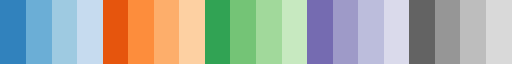

In [94]:
mpl.colormaps["tab20c"]

/tmp/ipykernel_2213/3409460468.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y,


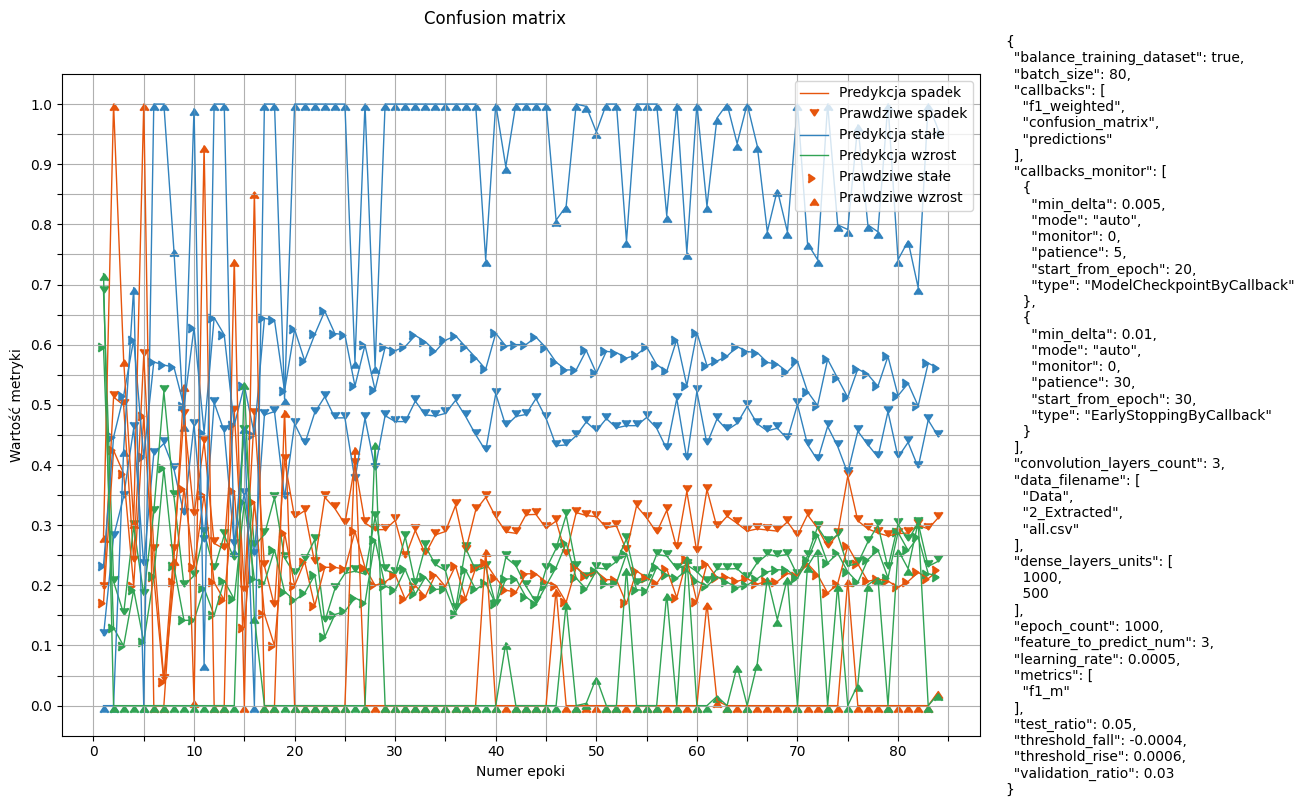

In [30]:
metric = "f_weighted_validation"
metric = "confusion_matrix_validation"

model = "cnn"
dataset = "all"
title = "Confusion matrix"

_case_dirs = case_dirs_cnn if model == "cnn" else case_dirs_cdt
_case_dirs = _case_dirs[dataset]
_case_dirs = {
    k: {
        "data": _case_dirs[k][metric],
        "config": _case_dirs[k]["config"],
    } for k in _case_dirs.keys()
}

for k in _case_dirs.keys():
    _plot_label_config_store = []
    
    d = _case_dirs[k]
    t = json.dumps(d["config"], sort_keys=True, indent=2)
    y_matrix = d["data"]
    y_matrix_freq = y_matrix / y_matrix[0].sum(axis=1).reshape((-1,1))
    
    x = range(1, y_matrix_freq.shape[0]+1)


    fig = plt.figure(figsize=(10, 8))
    fig.suptitle(title)


    ax = fig.add_subplot()
    x_tics = np.arange(0, len(x) + 11, 5)
    ax.set_xticks(x_tics)
    ax.set_xticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(x_tics)])
    ax.set_xlabel("Numer epoki")

    # ax.set_ylim(0, 1)
    y_tics = np.arange(0, 1.05, 0.05)
    ax.set_yticks(y_tics)
    ax.set_yticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(y_tics)])
    ax.set_ylabel("Wartość metryki")

    ax.grid(axis="both")
    
    for row in range(y_matrix_freq.shape[1]):
        for col in range(y_matrix_freq.shape[2]):
            y = y_matrix_freq[:, row, col]

            if (0, col) not in _plot_label_config_store:
                _plot_label_config_store.append((0, col))
                _label = cm_label_dict[(0, col)]
            else:
                _label = None
            ax.plot(x, y, linewidth=1,
                    c=cm_color_dict[col],
                    label=_label)

            if (1, row) not in _plot_label_config_store:
                _plot_label_config_store.append((1, row))
                _label = cm_label_dict[(1, row)]
            else:
                _label = None
            ax.scatter(x, y,
                       marker=cm_marker_dict[row],
                       c=cm_color_dict[col],
                       label=_label)

    ax.legend()
    fig.text(1.01, 0, t, ha='left', wrap=False)

    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
        
    # path_to_save = os.path.join("tmp_plots", model, dataset, metric, "_".join(k.split(os.sep)) + ".png")
    # os.makedirs(os.path.dirname(path_to_save), exist_ok=True)
    # fig.savefig(path_to_save, bbox_inches='tight')

    # plt.close()
    break


In [31]:
a, b

(-0.05, 1.05)

In [92]:
mpl.colormaps["tab20c"]

(0.19215686274509805, 0.5098039215686274, 0.7411764705882353, 1.0)

In [24]:
y_matrix[30]

array([[ 400,  765,  455],
       [ 441, 1490,  565],
       [   0,  259,    0]])

In [19]:
y_matrix[0].sum(axis=1).reshape((-1,1))

array([[1620],
       [2496],
       [ 259]])

In [20]:
y_matrix[0] / y_matrix[0].sum(axis=1).reshape((-1,1))

array([[0.19506173, 0.11666667, 0.6882716 ],
       [0.17107372, 0.23277244, 0.59615385],
       [0.28185328, 0.        , 0.71814672]])

In [70]:
y_matrix[0,2,0]

73

In [57]:
y_matrix.sum(axis=-1).sum(axis=-1)

TypeError: 'list' object cannot be interpreted as an integer

In [5]:
_case_dirs = case_dirs_cnn
_case_dirs = _case_dirs["all"]
_case_dirs = {
    k: {
        "data": _case_dirs[k]["f_weighted_validation"],
        "config": _case_dirs[k]["config"],
    } for k in _case_dirs.keys()
}
_case_dirs

{'Models/Final/CNN/all/2023-06-12_09-52-53_0': {'data': array([0.2792243 , 0.53173132, 0.59634082, 0.38950122, 0.56609433,
         0.40985977, 0.09150914, 0.37942854, 0.56389061, 0.53141497,
         0.46610029, 0.49143835, 0.44159928, 0.52521953, 0.36333102,
         0.51545072, 0.42052703, 0.31660886, 0.50894467, 0.52698838,
         0.50749235, 0.42372971, 0.61804639, 0.5528921 , 0.51503838,
         0.52200416, 0.51262596, 0.48488804, 0.4983419 , 0.51277762,
         0.42577397, 0.51768526, 0.44121834, 0.48359283, 0.49928492,
         0.57991846, 0.44514308, 0.51938364, 0.5030359 , 0.56104927,
         0.49644259, 0.48974064, 0.53642012, 0.55961618, 0.4989949 ,
         0.46538694, 0.42591796, 0.50796985, 0.52432437, 0.50786138,
         0.49791493, 0.49234434, 0.46449666, 0.5403003 , 0.52505536,
         0.47131171, 0.52056062, 0.4734498 , 0.55020292, 0.47349341,
         0.53569136, 0.49548682, 0.51099174, 0.51384981, 0.50261953,
         0.49840568, 0.50240238, 0.49329801, 0.50

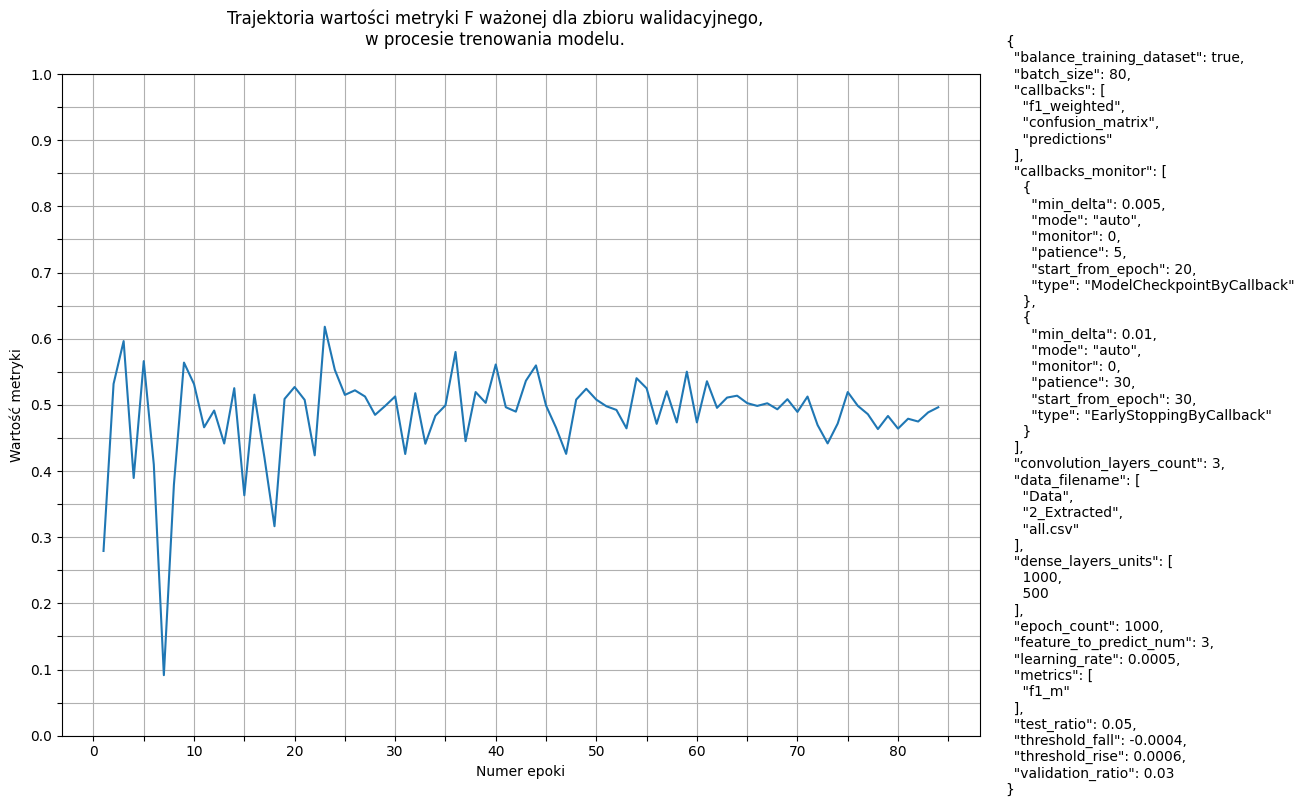

In [7]:
d = _case_dirs[list(_case_dirs.keys())[0]]
t = json.dumps(d["config"], sort_keys=True, indent=2)
y = d["data"]
x = range(1, len(y)+1)


fig = plt.figure(figsize=(10, 8))
fig.suptitle("Trajektoria wartości metryki F ważonej dla zbioru walidacyjnego,\n"
             "w procesie trenowania modelu.")


ax = fig.add_subplot()
x_tics = np.arange(0, len(x) + 11, 5)
ax.set_xticks(x_tics)
ax.set_xticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(x_tics)])
ax.set_xlabel("Numer epoki")

ax.set_ylim(0, 1)
y_tics = np.arange(0, 1.05, 0.05)
ax.set_yticks(y_tics)
ax.set_yticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(y_tics)])
ax.set_ylabel("Wartość metryki")

ax.grid(axis="both")

ax.plot(x, y)

fig.text(1.01, 0, t, ha='left', wrap=False)

fig.tight_layout()
fig.subplots_adjust(top=0.9)



In [36]:
plt.close()

In [72]:
np.arange(9).reshape((3,3))

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [99]:

np.arange(0, 3, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9])

In [142]:
os.sep

'/'

In [78]:
import os
from PIL import Image


In [70]:
os.chdir("/home/bartko/Downloads/New Folder (1)")

In [76]:
filenames = next(os.walk("."))[2]
filenames

['confusion_matrix_Amazon_5_cdt_1.png',
 'confusion_matrix_Amazon_5_cdt_3.png',
 'f1_m_Amazon_5_cdt_compare.png',
 'f1_m_Amazon_5_cnn_compare.png',
 'f_weighted_validation_all_cdt_compare.png',
 'f_weighted_validation_all_cnn_compare.png',
 'f_weighted_validation_Amazon_5_cdt_compare.png',
 'f_weighted_validation_Amazon_5_cnn_compare.png',
 'val_f1_m_Amazon_5_cdt_compare.png',
 'val_f1_m_Amazon_5_cnn_compare.png']

In [79]:
img = Image.open(filenames[0])
width, height = img.size
width, height

(1316, 807)

In [83]:
img2 = img.crop((0, 50, width, height))
img2.save("tmp.png")

In [ ]:
for fname in filenames:
    img = Image.open(fname)
    width, height = img.size
    img2 = img.crop((0, 50, width, height))
    img2.save(fname)